In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 신경망 학습

## 데이터에서 학습

### 데이터 주도 학습
기계학습의 중심에는 `데이터` 존재

### 훈련, 시험 데이터
나누는 이유: 원하는 것이 범용적으로 사용할 수 있는 모델이기 때문이다. 즉, `범용 능력`을 제대로 평가하기 위해 두 개의 데이터로 나눈다.

`오버피팅`: 한 데이터셋에만 지나치게 최적화된 상태

## 손실 함수
신경망에서 '하나의 지표'를 기준으로 최적의 매개변수 값을 탐색함. 이 때 사용되는 지표가 `손실 함수(loss function)`이다.

### 오차제곱합
$$E = \frac{1}{2}\sum_{k}(y_k - t_k)^2$$
변수 | 설명
:---:|----
k    | 데이터 차원 수
$y_k$|신경망의 출력
$t_k$|정답 레이블

In [3]:
# 오차제곱합
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

### 교차 엔트로피 오차
$$E=-\sum_{k}t_k\log y_k$$
여기서 $\log$는 자연로그 ($\log_e$)다.

In [5]:
# 교차 엔트로피 오차
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

delta는 np.log에 0이 들어가 -inf값이 되지 않게 한다.

### 미니 배치 학습
모든 훈련 데이터에 대한 손실 함수의 합
* 교차 엔트로피 오차
$$E=-\frac{1}{N} \sum_{n} \sum_{k} t_{nk}\log y_{nk}$$

모든 데이터를 대상으로 손실 함수의 합을 구하려면 시간이 오래 걸린다. 이 경우 데이터 일부를 추려 전체의 '근사치'로 이용하는 방법을 이용할 수 있다. 신경망 학습에서는 일부만 골라 학습을 수행하는 것을 `미니배치 학습`이라고 한다. 데이터의 일부를 `미니배치`라고 한다.

In [50]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [7]:
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [8]:
# 훈련 데이터에서 무작위로 10장만 빼내기
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### (배치용) 교차 엔트로피 오차 구현

In [13]:
# 정답 레이블이 one-hot encoding인 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [18]:
# 정답 레이블이 one-hot encoding이 아닌 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### 손실 함수 설정 이유
정확도를 지표로 삼으면 안되는 이유: 정확도에는 연속적인 변화가 없기 때문에 미분이 대부분의 장소에서 0이 되기 때문
손실 함수를 지표로 삼는 이유: 매개변수의 값이 조금만 변해도 이에 반응하여 연속적으로 손실 함수의 값이 변하며, 미분 값도 연속적으로 변하기 때문

## 수치 미분
기울기의 정의와 성질

### 미분
$$\frac{df(x)}{dx} = \lim_{h \to 0}\frac{f(x+h) - f(x)}{h}$$

In [1]:
# 나쁜 구현
def numerical_diff(f, x):
    h = 1e-50       # 반올림 오차(rounding error) 문제 
    return (f(x + h) - f(x)) / h

# 오차를 줄이기 위해 중심(중앙) 차분을 사용
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2*h)

### 수치 미분 예시

In [2]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

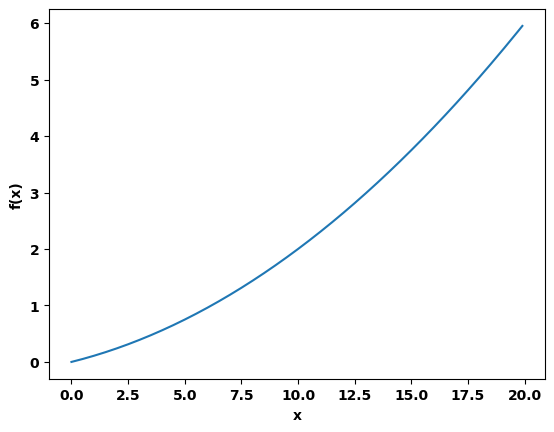

In [4]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [5]:
# x = 5 일 때, x = 10 일 때 기울기
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


### 편미분
$$f(x_0, x_1) = x_0^2 + x_1^2$$

In [6]:
def function_2(x):
    return x[0]**2 + x[1]**2 # np.sum(x**2)

In [7]:
# x0 = 3, x1 = 4 일 때, x0에 대한 편미분
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0) 

6.00000000000378

In [8]:
# x0 = 3, x1 = 4 일 때, x1에 대한 편미분
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0) 

7.999999999999119

## 기울기
**기울기**: 모든 변수의 편미분을 벡터로 정리한 것

In [10]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

In [12]:
print(numerical_gradient(function_2, np.array([3., 4.])), \
        numerical_gradient(function_2, np.array([0., 2.])), \
        numerical_gradient(function_2, np.array([3., 0.])))

[6. 8.] [0. 4.] [6. 0.]


기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향이다.

### 경사법(경사 하강법)
경사법: 현 위치에서 기울어진 방향으로 일정 거리만큼 이동 후 이동한 곳에서 또다시 기울기를 구하고 기울어진 방향으로 나아가기를 반복하는 과정으로 함수의 값을 점차 줄이는 것
$$
x_0 = x_0 - \eta \frac{\partial f}{\partial x_0} \\
x_1 = x_1 - \eta \frac{\partial f}{\partial x_1}
$$
$\eta$(학습률): 매개변수 값을 얼마나 갱신하느냐를 정하는 것

In [13]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr*grad
    return x

In [17]:
init_x = np.array([-3., 4.])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [19]:
# 학습률이 너무 크거나 작으면 좋은 결과를 얻을 수 없음
init_x = np.array([-3., 4.])
print(gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100))
init_x = np.array([-3., 4.])
print(gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100))

[-2.58983747e+13 -1.29524862e+12]
[-2.99999994  3.99999992]


### 신경망에서의 기울기

In [33]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3) # 정규분포로 초기화
    
    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [34]:
net = simpleNet()
print(net.W)

[[-1.76974458 -0.55827334  2.32056154]
 [-0.09964616  0.11512958 -0.07206914]]


In [35]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-1.15152829 -0.23134738  1.3274747 ]


In [36]:
np.argmax(p)

2

In [37]:
t = np.array([1, 0, 0])
net.loss(x, t)

2.7369023000169

In [38]:
def f(W):
    return net.loss(x, t)

f = lambda w: net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[-0.56113679  0.0975344   0.46360238]
 [-0.84170518  0.14630161  0.69540358]]


## 학습 알고리즘 구현
1. 미니배치
2. 기울기 산출
3. 매개변수 갱신
4. 반복

`확률적 경사 하강법(SGD)` stochastic gradient descent

### 2층 신경망 클래스 구현

In [40]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [41]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [42]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

### 미니배치 학습 구현

In [ ]:
from common import gradient
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 하이퍼파라미터
iters_num = 1000 # 반복횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradi

    # 매개 변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

학습 횟수가 늘어가면서 손실 함수의 값이 줄어든다.

### 시험 데이터 평가

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 하이퍼파라미터
iters_num = 1000 # 반복횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1 epoch당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)

    # 매개 변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1 epoch당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'train acc, test acc | {str(train_acc)}, {str(test_acc)}')